In [24]:
from MEDSAM_helper_functions import * # show_mask, show_box, medsam_inference

import sys, os
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars

setup_data_vars()

In [25]:
import argparse
import sys

parser = argparse.ArgumentParser(description="Preprocess CT/MR images")
parser.add_argument('anatomy', type=str, help='anatomy of the images')
parser.add_argument('axis', type=int, help='axis 0,1,2')

original_args = sys.argv
sys.argv = [original_args[0], 'Anorectum', 0]

args = parser.parse_args()

In [26]:
pre_processed_imgs = os.path.join(os.environ.get('MedSAM_preprocessed'), 'imgs', f'axis{args.axis}')
pre_processed_gts = os.path.join(os.environ.get('MedSAM_preprocessed'), 'gts', args.anatomy, f'axis{args.axis}')
pre_processed_imgs, pre_processed_gts

('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/imgs/axis0',
 '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/gts/Anorectum/axis0')

In [27]:
from tqdm import tqdm

# Get the image ids and arrange them into slices
gt_slices = os.listdir(pre_processed_gts)
get_id = lambda x: int(x.split('_')[3].split('-')[0])
get_slice = lambda x: int(x.split('_')[3].split('-')[1].split('.')[0])

slices_per_sample = {}
for image_slice in tqdm(os.listdir(pre_processed_gts)):
    gt_id = get_id(image_slice)
    gt_slice = get_slice(image_slice)

    if gt_id not in slices_per_sample:
        slices_per_sample[gt_id] = [gt_slice, gt_slice] # (min, max)
    else:
        min_slice, max_slice = slices_per_sample[gt_id]
        slices_per_sample[gt_id] = (min([min_slice, gt_slice]), max([max_slice, gt_slice]))

print(f'Found {len(gt_slices)} distinct image slices for this axis ({args.axis}) and anatomy ({args.anatomy})')
slice_intervals = [mx - mn + 1 for mn, mx in slices_per_sample.values()]
print(f'Average slices per sample: {np.mean(slice_intervals)}')
print(f'The most slices per sample: {np.max(slice_intervals)}')
print(f'The least slices per sample: {np.min(slice_intervals)}')

100%|██████████| 5196/5196 [00:00<00:00, 254416.87it/s]

Found 5196 distinct image slices for this axis (0) and anatomy (Anorectum)
Average slices per sample: 52.05
The most slices per sample: 74
The least slices per sample: 31


In [28]:
import cv2

def get_bounding_boxes(resized_gt):
    # Find contours in the segmentation map
    contours, _ = cv2.findContours(resized_gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize list to store bounding boxes
    bounding_boxes = []

    # Loop through contours to find bounding boxes
    for contour in contours:
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append([x, y, x + w, y + h])  # Format: (x_min, y_min, x_max, y_max)

    return np.array(bounding_boxes)

In [39]:


def visualise_bounding_box_with_prediction(array_image, array_gt_label, bounding_boxes=None, predicted_mask=None, show_boxes_of_predictions=False, save_title = None, sup_title = None):
    ncols = sum([2, int(bounding_boxes is not None), int(predicted_mask is not None)])

    _, axes = plt.subplots(1, ncols, figsize=(5 * ncols, 5))
    axes[0].imshow(array_image, cmap='gray')
    axes[0].set_title('Raw Image')

    alpha_mask_gt = np.where(array_gt_label > 0, 1, 0).astype(np.float32)
    axes[1].imshow(array_image, cmap='gray')
    axes[1].imshow(array_gt_label, alpha=alpha_mask_gt, cmap='viridis')
    axes[1].set_title('Ground Truth')

    currcol = 2

    if bounding_boxes is not None:
        assert len(bounding_boxes) >= 1
        axes[2].imshow(array_image, cmap='gray')
        for box in bounding_boxes:
            box = list(box)
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            axes[2].add_patch(
                plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
            )
        axes[2].set_title('Bounding Box From Segmentation')
        currcol += 1

    if predicted_mask is not None:

        alpha_mask_pred = np.where(predicted_mask > 0, 1, 0).astype(np.float32)
        axes[currcol].imshow(array_image, cmap='gray')
        axes[currcol].imshow(predicted_mask, alpha=alpha_mask_pred, cmap='viridis')
        axes[currcol].set_title('Predicted Mask')

        if show_boxes_of_predictions:
            bounding_boxes_of_predictions = get_bounding_boxes(predicted_mask)

            for box in bounding_boxes_of_predictions:
                box = list(box)
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                axes[currcol].add_patch(
                    plt.Rectangle((x0, y0), w, h, edgecolor="red", facecolor=(0, 0, 0, 0), lw=2)
                )
                
    plt.tight_layout()
    plt.suptitle(sup_title, y=1.05)
    
    if not save_title is None:
        save_path = '/'.join(save_title.split('/')[:-1])
        os.makedirs(save_path, exist_ok=True)
        
        plt.savefig(save_title)

In [30]:
import SimpleITK as sitk

def dice_similarity(gt, pred):
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

    ypred_sitk = sitk.GetImageFromArray(pred)
    y_gt_sitk = sitk.GetImageFromArray(gt)

    overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)
    return overlap_measures_filter.GetDiceCoefficient()

In [31]:
MedSAM_CKPT_PATH = os.path.join(os.environ.get('PROJECT_DIR'),  "models/MedSAM/work_dir/MedSAM/medsam_vit_b.pth")
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()
"model set to evaluation mode"

'model set to evaluation mode'

In [32]:
import torch
import bisect 
from torch.utils.data import Dataset, DataLoader

class SAM_Dataset(Dataset):

    def __init__(self, axis = args.axis, anatomy = args.anatomy):
        self.axis = axis
        self.anatomy = anatomy

        self.gt_slice_dir = os.path.join(os.environ.get('MedSAM_preprocessed'), 'gts', anatomy, f'axis{axis}')
        self.img_slice_dir = os.path.join(os.environ.get('MedSAM_preprocessed'), 'imgs', f'axis{axis}')
        
        self.slices_per_sample = {}
        for image_slice in os.listdir(self.gt_slice_dir):
            gt_id, gt_slice = self.get_id_and_slice_from_gt_path(image_slice)

            if gt_id not in self.slices_per_sample.keys():
                self.slices_per_sample[gt_id] = [gt_slice] # (min, max)
            else:
                bisect.insort(self.slices_per_sample[gt_id], gt_slice)

    def __len__(self):
        return sum([len(vs) for vs in self.slices_per_sample.values()])

    def __getitem__(self, idx):
        assert 0 <= idx < self.__len__(), f"Index {idx} is out of range for dataset of size {self.__len__()}"

        for img_ids, img_slices in self.slices_per_sample.items():
            if idx - len(img_slices) > 0:
                idx = idx - len(img_slices)
                continue
            else:
                curr_slice = img_slices[idx]
                break

        gt_slice_path = os.path.join(self.gt_slice_dir, self.gt_slice_format(img_ids, curr_slice))
        img_slice_path = os.path.join(self.img_slice_dir, self.img_slice_format(img_ids, curr_slice))

        # load in the image
        gt_array = np.load(gt_slice_path)
        img_array = np.load(img_slice_path)

        bounding_boxes = get_bounding_boxes(gt_array)

        img_array = torch.tensor(img_array).float().permute(2, 0, 1)

        # return img_array, gt_array, and bounding box pair
        return img_array, gt_array, bounding_boxes, img_ids, curr_slice

    def gt_slice_format(self, img_num: int, slice_num: int) -> str:
        return 'CT_' + self.anatomy + '_zzAMLART_' + str(img_num).zfill(3) + '-' + str(slice_num).zfill(3) + '.npy'

    def img_slice_format(self, img_num, slice_num):
        return 'CT_zzAMLART_' + str(img_num).zfill(3) + '-' + str(slice_num).zfill(3) + '.npy'
    
    def get_id_and_slice_from_gt_path(self, path: str):
        get_id = lambda x: int(x.split('_')[3].split('-')[0])
        get_slice = lambda x: int(x.split('_')[3].split('-')[1].split('.')[0])

        return get_id(path), get_slice(path)

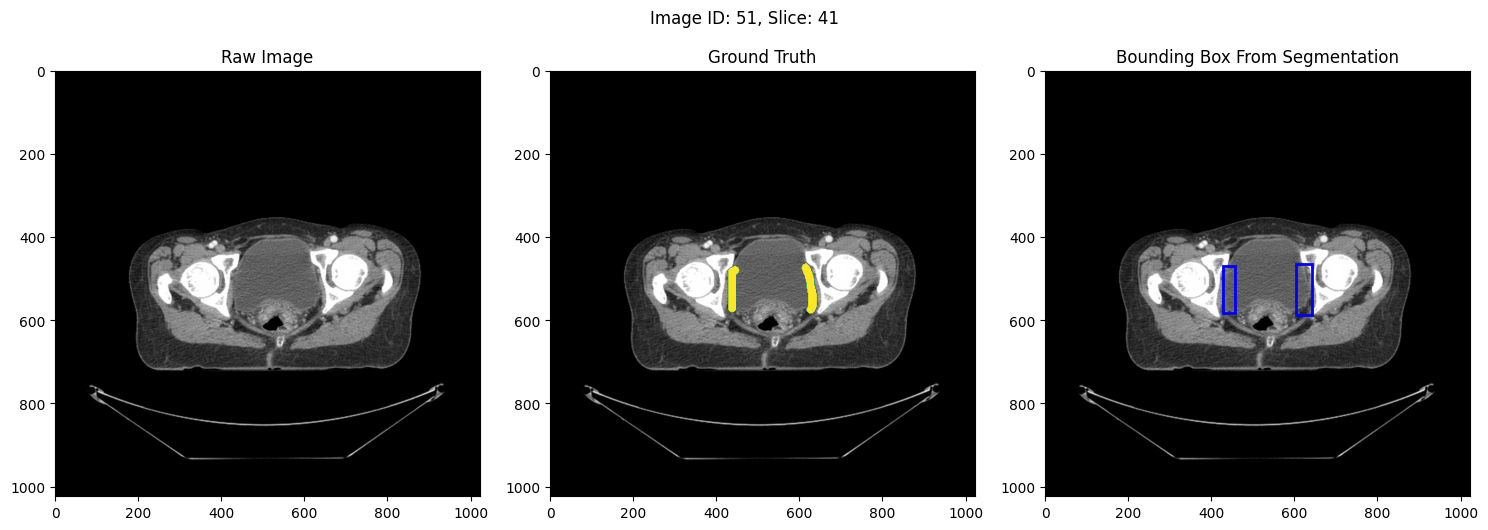

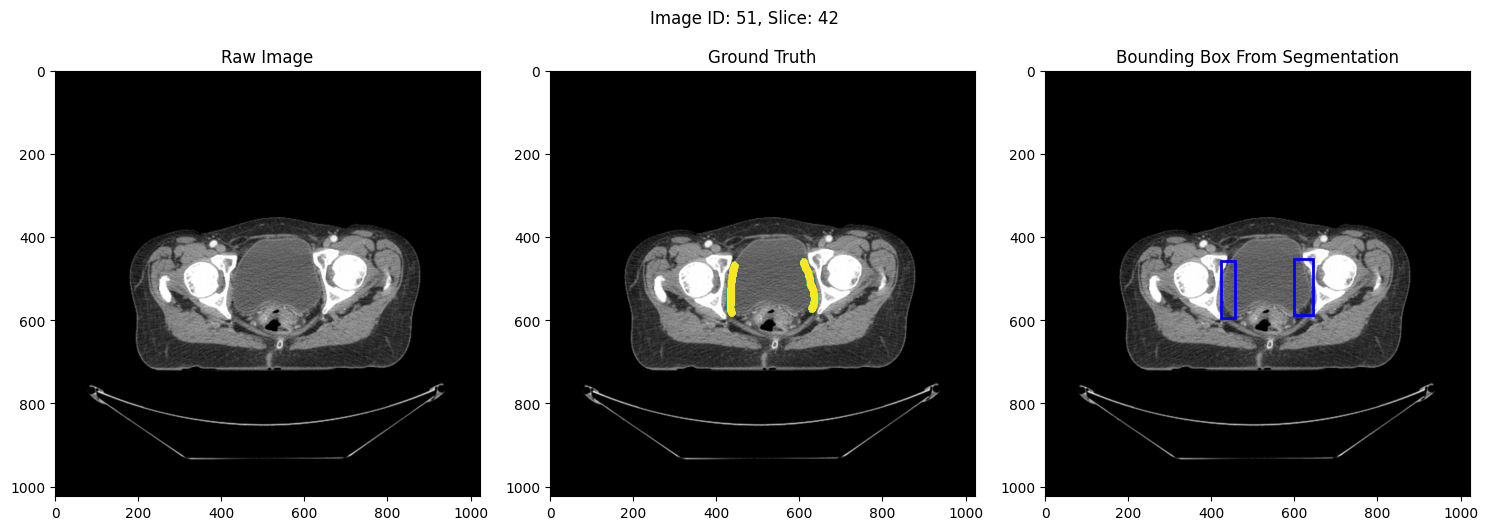

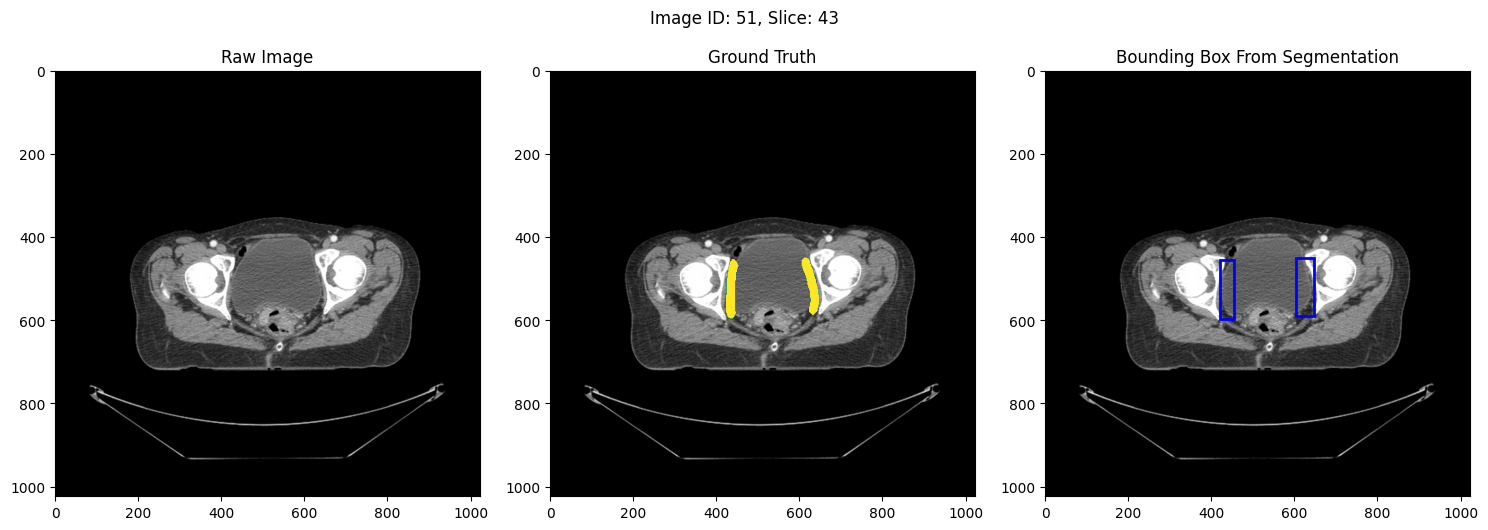

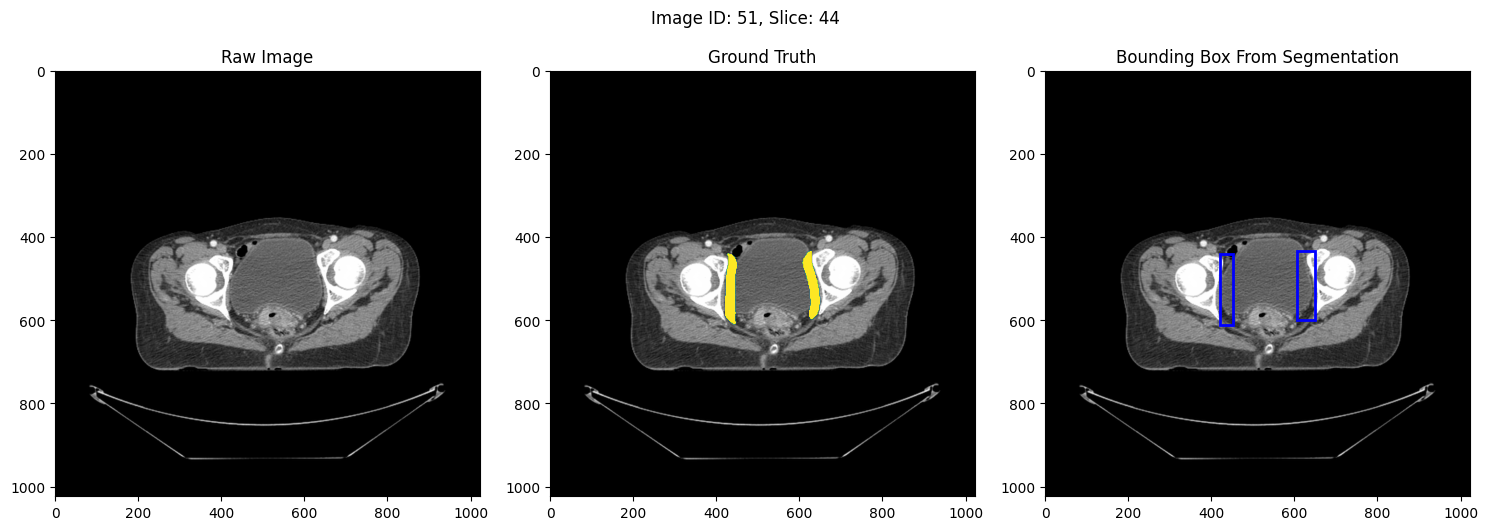

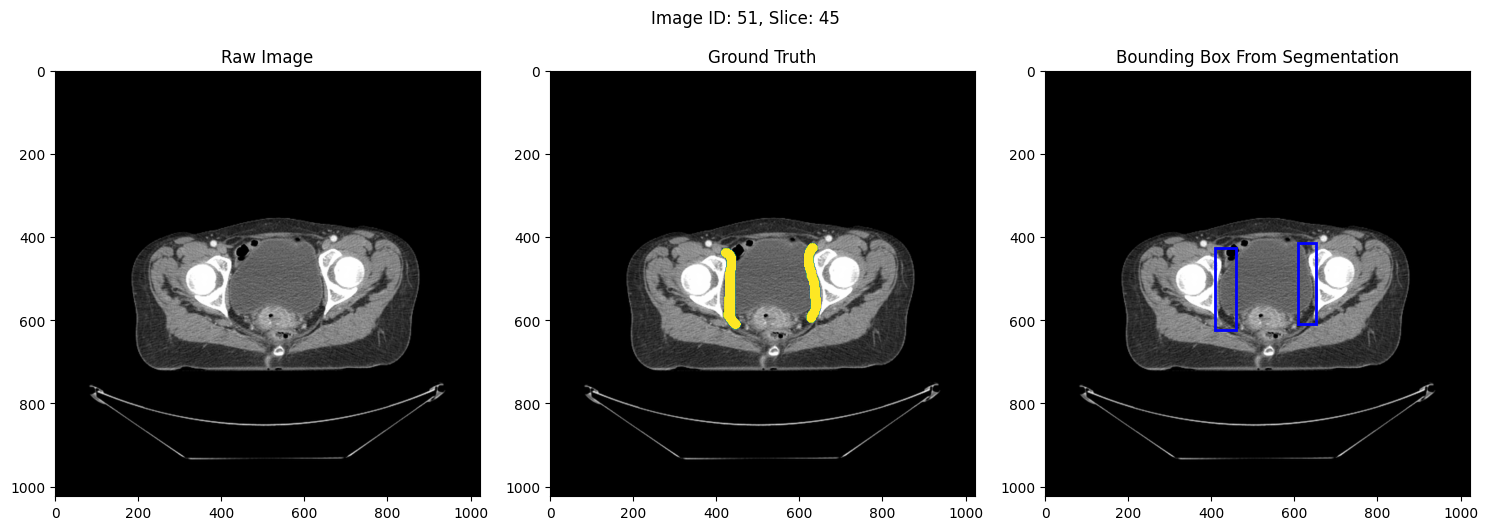

In [40]:
dataset = SAM_Dataset(axis=0, anatomy="CTVn")
loader = DataLoader(dataset, batch_size=5, shuffle=False)

for img, gt, boxes, imgids, currslice in loader:
    for i, g, b, ii, cs in zip(img, gt, boxes, imgids, currslice):
        visualise_bounding_box_with_prediction(i.permute(1, 2, 0).numpy(), g, b, None, show_boxes_of_predictions=True, sup_title=f"Image ID: {ii}, Slice: {cs}")
    break

In [10]:
dataset = SAM_Dataset(axis=0, anatomy="CTVn")
loader = DataLoader(dataset, batch_size=5, shuffle=False)

for img, gt, bounding_boxes in loader:
    img = img.to(device)
    B, C, H, W = img.shape

    with torch.no_grad():
            image_embedding = medsam_model.image_encoder(img)
        
    medsam_preds = medsam_inference(medsam_model, image_embedding, bounding_boxes , H, W)
#     combined_preds = np.logical_or.reduce(np.array(medsam_preds)).astype(np.uint8)
    
    break

In [1]:
import matplotlib.pyplot as plt

percentile = np.array(range(0, max_slice - min_slice + 1)) / (max_slice - min_slice + 1)
plt.plot(percentile, per_image_dice, label="Dice Score")
plt.hlines(np.mean(per_image_dice), 0, 1, linestyles = "dotted", label = "mean")
plt.xlabel('Percentile Across Slices')
plt.ylabel('Dice Score')
plt.title('How Dice Score changes as we move through the slices')
plt.legend()
plt.show()  

NameError: name 'np' is not defined